In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import math
from utils import *
import talib as tl
%matplotlib inline

In [2]:
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn_pandas import DataFrameMapper

In [3]:
data = read_ami_SPY_data()

In [4]:
data.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
1999-03-10,128.4687,129.2500,127.7812,129.1875,3950000
1999-03-11,129.6875,131.1875,128.8750,130.6250,6583700
1999-03-12,131.0000,131.0312,129.2187,129.3750,5286500
1999-03-15,129.9375,131.2500,129.5000,131.2187,5394400
1999-03-16,131.1250,131.6562,130.4687,130.7187,4547500


In [5]:
data['Weekday'] = data.index.dayofweek.map(lambda x: {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri'}.get(x))

In [6]:
data['Month'] = data.index.month

In [7]:
data[['Weekday', 'Month']].head()

,Weekday,Month
Date,,
1999-03-10,Wed,3
1999-03-11,Thu,3
1999-03-12,Fri,3
1999-03-15,Mon,3
1999-03-16,Tue,3


In [8]:
def binarize_column(data, col):
    mapper = DataFrameMapper([(col, LabelBinarizer())], df_out=True, default=None)
    data = mapper.fit_transform(data)
    return data

In [9]:
data['Last trading day of month'] = np.append((data[:-1].index.day > data[1:].index.day), False)

In [10]:
data['First trading day of month'] = np.insert((data[1:].index.day < data[:-1].index.day), 0, False)

In [11]:
data['End of Quarter'] = (data['Month'] % 3 == 0) & data['Last trading day of month']
data[data['End of Quarter'] == True].index

DatetimeIndex(['1999-03-31', '1999-06-30', '1999-09-30', '1999-12-31',
               '2000-03-31', '2000-06-30', '2000-09-29', '2000-12-29',
               '2001-03-30', '2001-06-29', '2001-09-28', '2001-12-31',
               '2002-03-28', '2002-06-28', '2002-09-30', '2002-12-31',
               '2003-03-31', '2003-06-30', '2003-09-30', '2003-12-31',
               '2004-03-31', '2004-06-30', '2004-09-30', '2004-12-31',
               '2005-03-31', '2005-06-30', '2005-09-30', '2005-12-30',
               '2006-03-31', '2006-06-30', '2006-09-29', '2006-12-29',
               '2007-03-30', '2007-06-29', '2007-09-28', '2007-12-31',
               '2008-03-31', '2008-06-30', '2008-09-30', '2008-12-31',
               '2009-03-31', '2009-06-30', '2009-09-30', '2009-12-31',
               '2010-03-31', '2010-06-30', '2010-09-30', '2010-12-31',
               '2011-03-31', '2011-06-30', '2011-09-30', '2011-12-30',
               '2012-03-30', '2012-06-29', '2012-09-28', '2012-12-31',
      

In [12]:
data['Closes down 1 day'] = data['Close'] < data.shift(1)['Close']

In [13]:
data['Closes down 2 day'] = data['Closes down 1 day'] & (data.shift(1)['Close'] < data.shift(2)['Close'])

In [14]:
data[['Close', 'Closes down 1 day', 'Closes down 2 day']].head(10)

,Close,Closes down 1 day,Closes down 2 day
Date,,,
1999-03-10,129.1875,False,False
1999-03-11,130.6250,False,False
1999-03-12,129.3750,True,False
1999-03-15,131.2187,False,False
1999-03-16,130.7187,True,False
1999-03-17,130.1562,True,True
1999-03-18,132.2500,False,False
1999-03-19,129.6875,True,False
1999-03-22,129.9375,False,False


In [15]:
data['Day'] = data.index.day

In [16]:
data.head(2)

,Open,High,Low,Close,Volume,Weekday,Month,Last trading day of month,First trading day of month,End of Quarter,Closes down 1 day,Closes down 2 day,Day
Date,,,,,,,,,,,,,
1999-03-10,128.4687,129.2500,127.7812,129.1875,3950000,Wed,3,False,False,False,False,False,10
1999-03-11,129.6875,131.1875,128.8750,130.6250,6583700,Thu,3,False,False,False,False,False,11


In [17]:
data['Closes %'] = data['Close'].pct_change().fillna(0)*100

In [18]:
data['Closes %'].head()

Date
1999-03-10    0.000000
1999-03-11    1.112724
1999-03-12   -0.956938
1999-03-15    1.425082
1999-03-16   -0.381043
Name: Closes %, dtype: float64

In [19]:
data['Lowest volume 5 days'] = data['Volume'].rolling(5).min() == data['Volume']

In [20]:
data.head(10)[['Volume', 'Lowest volume 5 days']]

,Volume,Lowest volume 5 days
Date,,
1999-03-10,3950000,False
1999-03-11,6583700,False
1999-03-12,5286500,False
1999-03-15,5394400,False
1999-03-16,4547500,False
1999-03-17,4524100,True
1999-03-18,3506300,True
1999-03-19,5526700,False
1999-03-22,4603800,False


In [21]:
data['Closes % 5 days'] = data['Close'].pct_change(5).fillna(0)*100

In [22]:
data[['Close', 'Closes % 5 days']].head(6)

,Close,Closes % 5 days
Date,,
1999-03-10,129.1875,0.00000
1999-03-11,130.6250,0.00000
1999-03-12,129.3750,0.00000
1999-03-15,131.2187,0.00000
1999-03-16,130.7187,0.00000
1999-03-17,130.1562,0.74984


In [23]:
data['OPEX week'] = (data['Day'] > 14) & (data['Day'] < 22)

In [24]:
data['Tomorrow is OPEX Friday'] = (data['Weekday'] == 'Thu') & data.shift()['OPEX week']

In [25]:
data['Today is OPEX Friday'] = (data['Weekday'] == 'Fri') & data['OPEX week']

In [26]:
data.iloc[6:9]

,Open,High,Low,Close,Volume,Weekday,Month,Last trading day of month,First trading day of month,End of Quarter,Closes down 1 day,Closes down 2 day,Day,Closes %,Lowest volume 5 days,Closes % 5 days,OPEX week,Tomorrow is OPEX Friday,Today is OPEX Friday
Date,,,,,,,,,,,,,,,,,,,
1999-03-18,129.7812,132.3750,129.7500,132.2500,3506300,Thu,3,False,False,False,False,False,18,1.608682,True,1.244019,True,True,False
1999-03-19,132.3125,132.6250,129.6875,129.6875,5526700,Fri,3,False,False,False,True,False,19,-1.937618,False,0.241546,True,False,True
1999-03-22,130.0625,130.5937,129.4218,129.9375,4603800,Mon,3,False,False,False,False,False,22,0.192771,False,-0.976385,False,False,False


In [27]:
data['Before OPEX week'] = (data['Day'] > 7) & (data['Day'] < 15)

In [28]:
monthly_max = data['Close'].resample('M').max()
monthly_max.head()

Date
1999-03-31    132.2500
1999-04-30    137.2500
1999-05-31    137.3437
1999-06-30    137.0000
1999-07-31    141.8125
Freq: M, Name: Close, dtype: float64

In [29]:
monthly_max = monthly_max.resample(rule='1D', kind='timestamp').last().bfill()
monthly_max.head()

Date
1999-03-31    132.25
1999-04-01    137.25
1999-04-02    137.25
1999-04-03    137.25
1999-04-04    137.25
Freq: D, Name: Close, dtype: float64

In [30]:
data['Highest closing price of the month'] = data['Last trading day of month'] & (data['Close'] == monthly_max[data.index])
data[data['Highest closing price of the month'] == True].head()

,Open,High,Low,Close,Volume,Weekday,Month,Last trading day of month,First trading day of month,End of Quarter,...,Closes down 2 day,Day,Closes %,Lowest volume 5 days,Closes % 5 days,OPEX week,Tomorrow is OPEX Friday,Today is OPEX Friday,Before OPEX week,Highest closing price of the month
Date,,,,,,,,,,,,,,,,,,,,,
1999-06-30,134.6250,137.5000,133.8437,137.0000,16856100,Wed,6,True,False,True,...,False,30,1.811426,False,2.983360,False,False,False,False,True
1999-10-29,135.8437,137.6875,135.7187,137.0000,10988600,Fri,10,True,False,False,...,False,29,1.811426,False,5.308712,False,False,False,False,True
1999-12-31,146.8437,147.5000,146.2500,146.8750,3172700,Fri,12,True,False,True,...,False,31,0.159847,False,0.266718,False,False,False,False,True
2000-08-31,151.0625,153.0937,150.9062,152.3437,4863100,Thu,8,True,False,False,...,False,31,1.330285,False,0.681504,False,False,False,False,True
2001-04-30,126.4500,127.2700,124.6700,126.6600,10766900,Mon,4,True,False,False,...,False,30,0.699634,False,3.615838,False,False,False,False,True


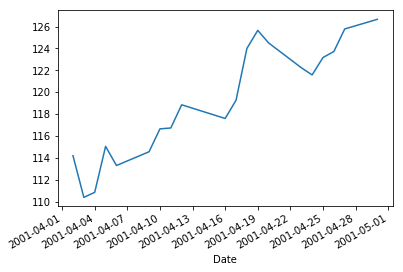

In [31]:
data['Close']['2001-04'].plot()

In [32]:
data['Closes % yesterday'] = data['Closes %'].shift(1).fillna(0)
data['First trading day of month yesterday'] = data['First trading day of month'].shift(1).fillna(False)
data[['First trading day of month', 'First trading day of month yesterday', 'Closes % yesterday']].iloc[15:18]

,First trading day of month,First trading day of month yesterday,Closes % yesterday
Date,,,
1999-03-31,False,False,-0.524184
1999-04-01,True,False,-1.604753
1999-04-05,False,True,0.754586


In [39]:
data['Thursday before Labor Day'] = (data['Weekday'] == 'Thu') & (((data['Month'] == 8) & (data['Day'] > 27)) | ((data['Month'] == 9) & (data['Day'] < 4)))

In [40]:
data['Friday before Labor Day'] = (data['Weekday'] == 'Fri') & (((data['Month'] == 8) & (data['Day'] > 28)) | ((data['Month'] == 9) & (data['Day'] < 5)))

In [41]:
data['Friday before Columbus Day'] = (data['Weekday'] == 'Fri') & (data['Month'] == 10) & (data['Day'] > 4) & (data['Day'] < 12) 

In [42]:
data['Thursday before Pres Day'] = (data['Weekday'] == 'Thu') & (data['Month'] == 2) & (data['Day'] > 10) & (data['Day'] < 18) 

In [43]:
data['Closes at 4 day high'] = data['High'].rolling(4).max() == data['Close']

In [46]:
data[['Closes at 4 day high', 'Close', 'High']].tail(10)

,Closes at 4 day high,Close,High
Date,,,
2018-01-04,False,271.61,272.16
2018-01-05,False,273.42,273.56
2018-01-08,False,273.92,274.10
2018-01-09,False,274.54,275.25
2018-01-10,False,274.12,274.42
2018-01-11,True,276.12,276.12
2018-01-12,False,277.92,278.11
2018-01-16,False,276.97,280.09
2018-01-17,False,279.61,280.05
